# Определение стоимости автомобилей

Разработка модели для предсказания стоимости подержанных автомобилей по его техническим характеристикам и комплектации для дальнейшего ее использования в специальном приложении. Указанное приложение будет применяться заказчиком – сервис по продаже подержанных автомобилей. 
Приоритетными критериями для выбора модели являются ее время обучения, скорость и качество предсказания.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('autos.csv')
display(df.tail())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [3]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
column_date = ['DateCrawled','DateCreated','LastSeen']
df[column_date] = df[column_date].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [6]:
df['DateCreated_month'], df['DateCreated_year'] = df['DateCreated'].dt.month, df['DateCreated'].dt.year

In [7]:
df[df['Gearbox'].isna()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCreated_month,DateCreated_year
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47,3,2016
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46,4,2016
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43,3,2016
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02,3,2016
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34,3,2016


### Промежуточные комментарии

Категориальные признаки DateCrawled, DateCreated, LastSeen были преобразованы в тип данных  datetime, так как предполагалось, что в дальнейшем они будут использоваться для вычисления периода времени нахождения объявления до его снятия либо скачивания с базы. Но непонятно несколько моментов: время создания анкеты представлено с одинаковым временем для всех, а время скачивания из базы – это для исследований? Также непонятно с последним временем активности клиента, он же, наверное, мог заходить просто на сайт и это засчиталось бы активностью. В общем из-за некоторого непонимания данных признаков (ожидания отличаются от реального понимания) в дальнейшем они не используются в обучении моделей, кроме фильтрации по году и месяцу регистрации, что реализовано далее.  

In [8]:
column_num = ['Price','RegistrationYear','Kilometer','Power']

In [9]:
df[column_num].describe()

,Price,RegistrationYear,Kilometer,Power
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,128211.172535,110.094337
std,4514.158514,90.227958,37905.341530,189.850405
min,0.000000,1000.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,125000.000000,69.000000
50%,2700.000000,2003.000000,150000.000000,105.000000
75%,6400.000000,2008.000000,150000.000000,143.000000
max,20000.000000,9999.000000,150000.000000,20000.000000


In [10]:
max(df['DateCreated_year'])

2016

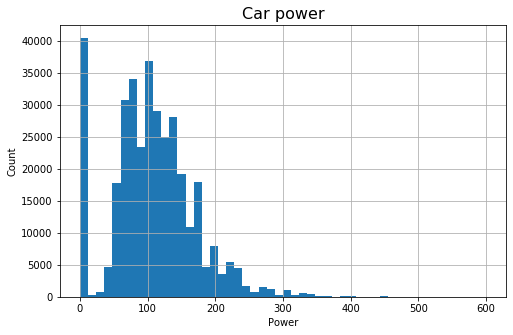

In [11]:
df['Power'].hist(bins = 50, range = (0, 600), figsize = (8,5))
plt.title('Car power', fontsize=16)
plt.xlabel('Power')
plt.ylabel('Count')
plt.show()    

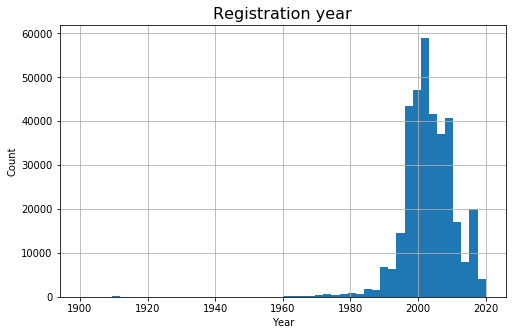

In [12]:
df['RegistrationYear'].hist(bins = 50, range = (1900, 2020),figsize = (8,5))
plt.title('Registration year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Count')
plt.show() 

In [13]:
df = df.drop(df[((df['RegistrationYear'] == df['DateCreated_year']) & 
                (df['RegistrationMonth'] > df['DateCreated_month'])) | (df['RegistrationYear'] < 1932) | (df['RegistrationYear'] > df['DateCreated_year']) ].index)
display(df.shape)

(334422, 18)

### Промежуточные комментарии
В процессе изучения данных был рассмотрен год регистрации автомобиля (данные месяца регистрации были также изучены. Считаю, что они не должны влиять на стоимость автомобиля. Даже специально не очищались объявления с месяцем – 0. Возможно, продавцы не придали значения данному параметру и поэтому автоматом проставилcя 0). Диапазон года регистрации автомобиля составляет от 1000г.до 9999г.
С учетом того, что крайняя дата создания объявления не превышает 2016 год, были удалены следующие объявления, в которых: 

- год регистрации автомобиля превышает 100-летний возраст владельца (с добавлением 18 лет, когда можно производить подобные продажи);
- год регистрации превышает год создания объявления;
- год регистрации превышает год соответствует году создания объявления, но месяц регистрации превышает месяц создания объявления.

In [14]:
df['NotRepaired'] = df[(df['Kilometer'] > 50000) &  
                                (df['DateCreated_year'] - df['RegistrationYear'] > 5)]['NotRepaired'].fillna('yes')

In [15]:
df = df.fillna('unknown')
display(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCreated_month,DateCreated_year
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,yes,2016-03-24,0,70435,2016-04-07 03:16:57,3,2016
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,unknown,2016-03-24,0,66954,2016-04-07 01:46:50,3,2016
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes,2016-03-14,0,90480,2016-04-05 12:47:46,3,2016
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,3,2016
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,3,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49,3,2016
354365,2016-03-14 17:48:27,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown,2016-03-14,0,39576,2016-04-06 00:46:52,3,2016
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12,3,2016
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26,3,2016


### Промежуточные комментарии

Помимо аномальных значений в данных присутствуют пропуски. Одна часть из них в признаке NotRepaired, где их насчитывалось около 20% (до предыдущих фильтраций) от всех данных, была заполнена ответом да для тех объявлений, где разница между годом подачи объявления и регистрации автомобиля превышала 5 лет и вместе с этим пробег превышал 50000 км.
Остальные пропуски во всех признаках заполнялись значением «unknown», так как их труднее предсказать, а удалять не стоит, так как продавцы заполняют не все параметры автомобиля. 

In [16]:
df[df['Brand'] == 'sonstige_autos']

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCreated_month,DateCreated_year
59,2016-03-29 15:48:15,1,suv,1994,manual,286,unknown,150000,11,unknown,sonstige_autos,yes,2016-03-29,0,53721,2016-04-06 01:44:38,3,2016
306,2016-03-21 14:38:37,200,unknown,2009,unknown,0,unknown,10000,0,unknown,sonstige_autos,unknown,2016-03-21,0,6493,2016-03-24 02:47:34,3,2016
431,2016-03-20 20:45:27,3950,small,2004,auto,5,unknown,70000,5,gasoline,sonstige_autos,no,2016-03-20,0,90562,2016-04-03 04:17:08,3,2016
650,2016-03-30 11:55:46,15000,coupe,1971,unknown,0,unknown,5000,4,unknown,sonstige_autos,unknown,2016-03-30,0,51145,2016-04-07 02:45:10,3,2016
661,2016-04-01 15:56:27,9900,suv,2000,auto,250,unknown,150000,4,lpg,sonstige_autos,no,2016-04-01,0,17309,2016-04-07 14:56:03,4,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354062,2016-03-19 11:25:16,6000,small,2008,manual,155,unknown,150000,5,petrol,sonstige_autos,no,2016-03-19,0,63069,2016-04-07 00:46:42,3,2016
354073,2016-03-19 14:53:26,1750,unknown,1995,unknown,0,unknown,100000,12,unknown,sonstige_autos,yes,2016-03-19,0,6188,2016-04-01 01:47:17,3,2016
354083,2016-03-30 07:54:17,0,unknown,2000,unknown,0,unknown,150000,0,unknown,sonstige_autos,yes,2016-03-30,0,6686,2016-04-06 23:46:19,3,2016
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,unknown,150000,4,gasoline,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:25,3,2016


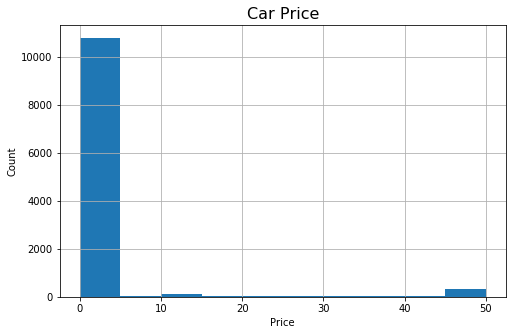

In [17]:
df['Price'].hist(bins = 10,range = (0,50),figsize = (8,5))
plt.title('Car Price', fontsize=16)
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [18]:
df = df.drop(df[(df['Price'] < 10)].index) 
display(df.shape)

(323584, 18)

In [19]:
df_new = df.query('Power < 2200 and Power > 30 ')

In [20]:
df_new[column_num].describe()

,Price,RegistrationYear,Kilometer,Power
count,291532.000000,291532.000000,291532.000000,291532.000000
mean,4894.765885,2002.700866,128366.045580,122.020444
std,4621.389675,6.288687,36619.195909,64.169283
min,10.000000,1937.000000,5000.000000,31.000000
25%,1350.000000,1999.000000,125000.000000,77.000000
50%,3200.000000,2003.000000,150000.000000,113.000000
75%,7000.000000,2007.000000,150000.000000,150.000000
max,20000.000000,2016.000000,150000.000000,2172.000000


### Промежуточные комментарии

Были удалены данные, с ценами ниже 10 евро.
Также из рассмотрения были исключены автомобили с мощностью менее 30 и более 2200 (максимальная мощность существующих автомобилей), предполагая, что, например, прицепы в данной подборке не представлены.

In [21]:
df_ord_1 = df_new[column_num].reset_index(drop=True)
display(df_ord_1)

,Price,RegistrationYear,Kilometer,Power
0,18300,2011,125000,190
1,9800,2004,125000,163
2,1500,2001,150000,75
3,3600,2008,90000,69
4,650,1995,150000,102
...,...,...,...,...
291527,7900,2010,150000,140
291528,3200,2004,150000,225
291529,1199,2000,125000,101
291530,9200,1996,150000,102


In [22]:
encoder = OrdinalEncoder()
column_categ = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
df_ord_2 = df_new[column_categ]
encoder = OrdinalEncoder()
df_ord_2 = pd.DataFrame(encoder.fit_transform(df_ord_2),
                            columns=column_categ)

In [23]:
df_ord_2.head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,2.0,1.0,227.0,2.0,1.0,1.0
1,6.0,0.0,117.0,2.0,14.0,2.0
2,5.0,1.0,116.0,6.0,38.0,0.0
3,5.0,1.0,101.0,2.0,31.0,0.0
4,4.0,1.0,11.0,6.0,2.0,2.0


In [24]:
df_for_lr = df_ord_1.join(df_ord_2)

In [25]:
df_for_lr

,Price,RegistrationYear,Kilometer,Power,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,18300,2011,125000,190,2.0,1.0,227.0,2.0,1.0,1.0
1,9800,2004,125000,163,6.0,0.0,117.0,2.0,14.0,2.0
2,1500,2001,150000,75,5.0,1.0,116.0,6.0,38.0,0.0
3,3600,2008,90000,69,5.0,1.0,101.0,2.0,31.0,0.0
4,650,1995,150000,102,4.0,1.0,11.0,6.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
291527,7900,2010,150000,140,4.0,1.0,116.0,2.0,38.0,0.0
291528,3200,2004,150000,225,4.0,1.0,140.0,6.0,30.0,2.0
291529,1199,2000,125000,101,1.0,0.0,106.0,6.0,32.0,0.0
291530,9200,1996,150000,102,0.0,1.0,223.0,2.0,38.0,0.0


In [26]:
def feat_targ(data, column):
    """Разделяет датасет на features и target при указании целевого признака"""
    features = data.drop(column,axis = 1)
    target = data[column]
    return features, target

In [27]:
def dividing(data1, data2):
    """Разделяет features и target на обучающую и тестовую выборки"""
    features_train, features_test, target_train, target_test = train_test_split(data1, data2, test_size=0.25, 
                                                                                  random_state=12345)
    print('Размер исходного датасета',data1.shape)
    print('Размер обучающей выборки',features_train.shape)
    print('Размер тестовой выборки',features_test.shape)
    print('Проверка суммарного размера выборок', features_train.shape[0] + features_test.shape[0] )
    return features_train, features_test, target_train, target_test

In [28]:
def scal(data_1, data_2):
    """Масштабирование данных"""
    scaler = StandardScaler()
    scaler.fit(data_1)
    pd.options.mode.chained_assignment = None
    data_1 = scaler.transform(data_1)
    data_2 = scaler.transform(data_2)
    return data_1, data_2

In [29]:
def rmse(target, pred):
    """Создание метрики для применения ее в GridSearchCV """
    return (mean_squared_error(target, pred)**0.5)
my_score = make_scorer(rmse, greater_is_better=False)

In [30]:
def predict_data(model,features_test, target_test):
    """Предсказание и измерение времени """
    start_time = datetime.now()
    pred_test = model.predict(features_test)
    end_time = datetime.now()
    time_predict = end_time - start_time
    rmse_test = rmse(target_test,pred_test)
    print('rmse_test:',round(rmse_test,2))
    print('time_predict:',time_predict)
    return rmse_test, time_predict


### Промежуточные комментарии

Данные подготовлены для исследования модели на основе линейной регрессии – закодированы категориальные признаки.

Также были написаны функции для дальнейшего применения при повторении операций во время исследования моделей.


## Обучение моделей

In [31]:
features_lr, target_lr = feat_targ(df_for_lr, 'Price')
features_tr_lr, features_test_lr, target_tr_lr, target_test_lr = dividing(features_lr, target_lr)

Размер исходного датасета (291532, 9)
Размер обучающей выборки (218649, 9)
Размер тестовой выборки (72883, 9)
Проверка суммарного размера выборок 291532


In [32]:
features_tr_s_lr, features_test_s_lr = scal(features_tr_lr, features_test_lr)

In [33]:
lr =  LinearRegression()
param_lr = {'normalize':[True,False]}

In [34]:
%%time
start_time = datetime.now()
model_lr = GridSearchCV(lr, param_lr, refit=True, scoring = my_score, cv=5)
best_model_lr = model_lr.fit(features_tr_s_lr, target_tr_lr)
end_time = datetime.now()
time_gs_lr = end_time - start_time
best_params_lr = best_model_lr.best_params_
print(best_params_lr)

{'normalize': False}
CPU times: user 1.23 s, sys: 814 ms, total: 2.04 s
Wall time: 2.03 s


In [35]:
%%time
start_time = datetime.now()
lr_best =  LinearRegression(normalize = True)
model_lr = lr_best.fit(features_tr_lr, target_tr_lr)
end_time = datetime.now()
time_fit_lr = end_time - start_time


CPU times: user 71.5 ms, sys: 15.7 ms, total: 87.1 ms
Wall time: 85.9 ms


In [36]:
rmse_test_lr, time_predict_lr = predict_data(model_lr,features_test_lr, target_test_lr)

rmse_test: 3154.87
time_predict: 0:00:00.065060


### Промежуточный комментарий

Первая рассматриваемая модель - линейная регрессия. Отличается высокой скоростью обучения. Для подбора лучшей модели с перебором гиперпараметров и применяя кросс-валидацию был выбран инструмент GridSearchCV. Линейная регрессия достаточно самодостаточная модель, поэтому выбрано минимальное количество изменяемых гиперпараметров, чтобы работал инструмент подбора и это - 'normalize':[True,False].
В итоге перебора малого количества гиперпараметров и кросс-валидации, состаящей из 5 выборок был выбран вариант: {'normalize': True}. Время обучение модели составило менее 1 секунды. RMSE для тестовой выборки составила  3154,87.

In [37]:
features_cbr, target_cbr = feat_targ(df_new[df_for_lr.columns], 'Price')
features_tr_cbr, features_test_cbr, target_tr_cbr, target_test_cbr = dividing(features_cbr, target_cbr)

Размер исходного датасета (291532, 9)
Размер обучающей выборки (218649, 9)
Размер тестовой выборки (72883, 9)
Проверка суммарного размера выборок 291532


In [38]:
cbr = CatBoostRegressor()
params_cbr = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1],
          'iterations': [700]}

In [39]:
%%time
start_time = datetime.now()
cbr_model = GridSearchCV(cbr, params_cbr, n_jobs=-1, refit=True,  scoring=my_score, cv = 3)
best_model_cbr = cbr_model.fit(features_tr_cbr, target_tr_cbr, verbose=100, cat_features= column_categ)
end_time = datetime.now()
time_gs_cbr = end_time - start_time
best_params_cbr = best_model_cbr.best_params_
print(best_params_cbr)

0:	learn: 4529.9220648	total: 194ms	remaining: 2m 15s
100:	learn: 2107.6817928	total: 20.5s	remaining: 2m 1s
200:	learn: 1919.6157038	total: 40.8s	remaining: 1m 41s
300:	learn: 1857.0708254	total: 1m 1s	remaining: 1m 21s
400:	learn: 1820.2385974	total: 1m 22s	remaining: 1m 1s
500:	learn: 1792.3284680	total: 1m 45s	remaining: 41.8s
600:	learn: 1771.2490581	total: 2m 6s	remaining: 20.8s
699:	learn: 1755.1231876	total: 2m 27s	remaining: 0us
0:	learn: 4549.1387128	total: 189ms	remaining: 2m 12s
100:	learn: 2108.8391075	total: 20.7s	remaining: 2m 2s
200:	learn: 1918.0378396	total: 41.2s	remaining: 1m 42s
300:	learn: 1855.5546094	total: 1m 1s	remaining: 1m 21s
400:	learn: 1814.0489845	total: 1m 22s	remaining: 1m 1s
500:	learn: 1786.0484782	total: 1m 43s	remaining: 41.3s
600:	learn: 1765.5234175	total: 2m 5s	remaining: 20.6s
699:	learn: 1749.4458480	total: 2m 25s	remaining: 0us
0:	learn: 4550.7557945	total: 176ms	remaining: 2m 3s
100:	learn: 2119.2599302	total: 20.5s	remaining: 2m 1s
200:	lea

In [40]:
%%time
start_time = datetime.now()
model_cbr = CatBoostRegressor(loss_function="RMSE", iterations=best_params_cbr['iterations'], 
                        depth = best_params_cbr['depth'], learning_rate = best_params_cbr['learning_rate'],  random_seed=12345)
model_cbr.fit(features_tr_cbr, target_tr_cbr, verbose=100, cat_features= column_categ) 
end_time = datetime.now()
time_fit_cbr = end_time - start_time


0:	learn: 4281.3230189	total: 937ms	remaining: 10m 54s
100:	learn: 1609.1775936	total: 1m 31s	remaining: 9m 5s
200:	learn: 1528.8361729	total: 3m 5s	remaining: 7m 40s
300:	learn: 1480.2747467	total: 4m 44s	remaining: 6m 16s
400:	learn: 1441.4127204	total: 6m 23s	remaining: 4m 46s
500:	learn: 1416.0242961	total: 8m 4s	remaining: 3m 12s
600:	learn: 1394.7732554	total: 9m 42s	remaining: 1m 35s
699:	learn: 1375.9576480	total: 11m 22s	remaining: 0us
CPU times: user 10min 43s, sys: 41.1 s, total: 11min 24s
Wall time: 11min 27s


In [41]:
rmse_test_cbr, time_predict_cbr = predict_data(model_cbr,features_test_cbr, target_test_cbr)

rmse_test: 1533.47
time_predict: 0:00:01.473297


### Промежуточные комментарии

Следующая модель – градиентный бустинг CatBoost. Для подбора лучшей модели с перебором гиперпараметров и применяя кросс-валидацию также использовался GridSearchCV. Изменялись следующие гиперпараметры: depth' и learning_rate. В итоге был выбран вариант: {'depth': 10, 'iterations': 1000, 'learning_rate': 0.1}. Время обучение лучшей модели составило более 11 минут. Для подбора гиперпараметров с учетом 700 итераций и кросс-валидации равной 3 понадобилось около 2х часов. 
В итоге RMSE для обучающей выборки составила – 1533,47.


In [42]:
df_lrb = df_new[df_for_lr.columns]

In [43]:
for item in column_categ:
    df_lrb[item] = df_lrb[item].astype("category").cat.codes +1

In [44]:
features_lgb, target_lgb = feat_targ(df_lrb[df_for_lr.columns], 'Price')
features_tr_lgb, features_test_lgb, target_tr_lgb, target_test_lgb = dividing(features_lgb, target_lgb)


Размер исходного датасета (291532, 9)
Размер обучающей выборки (218649, 9)
Размер тестовой выборки (72883, 9)
Проверка суммарного размера выборок 291532


In [45]:
lg = lgb.LGBMRegressor(silent=False)
param_lgb = {"max_depth": [25,50,75],
              "learning_rate" : [0.01, 0.1],
              "n_estimators": [100]
             }

In [46]:
%%time
start_time = datetime.now()
model_lgb  = GridSearchCV(lg, n_jobs=-1, param_grid=param_lgb, refit=True, cv = 3, scoring=my_score)
best_model_lgb = model_lgb.fit(features_tr_lgb, target_tr_lgb,verbose=100)
end_time = datetime.now()
time_gs_lgb = end_time - start_time
best_params_lgb = best_model_lgb.best_params_
print(best_params_lgb)


{'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 100}
CPU times: user 1min 31s, sys: 0 ns, total: 1min 31s
Wall time: 1min 33s


In [47]:
%%time
start_time = datetime.now()
train = lgb.Dataset(features_tr_lgb, label=target_tr_lgb)
params = best_params_lgb
lgbm = lgb.train(params, train, categorical_feature = column_categ)
end_time = datetime.now()
time_fit_lgb = end_time - start_time

CPU times: user 5.87 s, sys: 0 ns, total: 5.87 s
Wall time: 5.99 s


In [48]:
rmse_test_lgb, time_predict_lgb = predict_data(lgbm,features_test_lgb, target_test_lgb)

rmse_test: 1596.31
time_predict: 0:00:00.696634


### Промежуточные комментарии
Последняя рассматриваемая модель – градиентный бустинг LightGBM. Для подбора лучшей модели с перебором гиперпараметров и применяя кросс-валидацию также использовался GridSearchCV. Изменялись следующие гиперпараметры: max_depth и learning_rate. В итоге был выбран вариант: {learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 100}. Время обучение лучшей модели составило около 6 сек. Для подбора гиперпараметров с учетом n_estimators = 100 и кросс-валидации равной 3 понадобилось около двух минут. 
В итоге RMSE для тестовой выборки составила – 1596,31.


## Анализ моделей

In [49]:
res_all = np.array([['LinearRegression', round(rmse_test_lr,2), best_params_lr, time_gs_lr,time_fit_lr, time_predict_lr], 
                       ['CatBoost', round(rmse_test_cbr,2), best_params_cbr, time_gs_cbr,time_fit_cbr, time_predict_cbr],
                    ['LightGBM', round(rmse_test_lgb,2), best_params_lgb, time_gs_lgb,time_fit_lgb, time_predict_lgb]])
result_all = pd.DataFrame(res_all,columns = ['model','rmse', 'parameters','time_gs','time_fit','time_predict'])

In [50]:
result_all

,model,rmse,parameters,time_gs,time_fit,time_predict
0,LinearRegression,3154.87,{'normalize': False},00:00:02.032237,00:00:00.085883,00:00:00.065060
1,CatBoost,1533.47,"{'depth': 10, 'iterations': 700, 'learning_rat...",01:42:47.713439,00:11:27.505187,00:00:01.473297
2,LightGBM,1596.31,"{'learning_rate': 0.1, 'max_depth': 25, 'n_est...",00:01:33.764265,00:00:05.991875,00:00:00.696634


## Выводы
Для предсказания рыночной стоимости автомобиля, который клиент хочет продать, были обучены и исследованы три модели: LinearRegression, градиентный бустинг на основе CatBoost и LightGBM. В процессе исследования перебирались гиперпараметры для минимизации метрики RMSE. Также замерялось время подбора гиперпараметров, обучения и предсказания моделей.
Из таблицы видно, что наименьшее время обучения потребовалось для линейной регрессии (< 1 сек), но итоговая метрика rmse составила более 3000 евро.
Близкие метрики (более 1500 евро, что почти в 2 раза меньше чем для линейной регресии) оказались при обучении модели градиентный бустинг с помощью библиотеки LightGBM и CatBoost. 
Время обучения и предсказания модели с помощью библиотеки LightGBM составило около 5 секунд и  менее 1й секнды соответственно, в тоже время с помощью CatBoost – более 12 минут обучение и 1,5 секунды - предсказание , что, возможно, объясняется большим количеством итераций. Из-за этого и подбор гиперпараметров затянулся почти на 2 часа. Но положительным достоинством CatBoost является тот факт, что дополнительно нет неообходимости в кадировании категориальных признаков.

С учетом вышенаписанного, для работы приложения предсказания стоимости автомобиля с учетом его характеристик рекомендуется использовать градиентный бустинг с помощью библиотеки LightGBM.
